# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [46]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

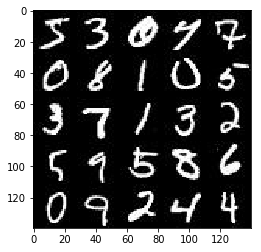

In [47]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

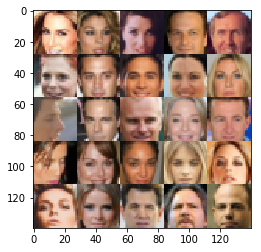

In [48]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [31]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # first convolution is 14x14x56
        out1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        out1 = tf.maximum(out1 * alpha, out1)
        
        # second convolution is 7x7x112
        out2 = tf.layers.conv2d(out1, 128, 4, strides=2, padding='same')
        out2 = tf.layers.batch_normalization(out2, training=True)
        out2 = tf.maximum(out2 * alpha, out2)
        
        # third convolution is also 4x4x256
        out3 = tf.layers.conv2d(out2, 256, 2, strides=2, padding='same')
        out3 = tf.layers.batch_normalization(out3, training=True)
        out3 = tf.maximum(out3 * alpha, out3)
        
        flat = tf.reshape(out3, (-1, 4*4*256))
        
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print(out2.shape)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [74]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        #print(z.shape)
        # 4x4x256
        out1 = tf.layers.dense(z, 7*7*256)
        out1 = tf.reshape(out1, (-1, 7, 7, 256))
        out1 = tf.layers.batch_normalization(out1, training=is_train)
        out1 = tf.maximum(out1 * alpha, out1)
        #out1 = tf.nn.dropout(out1, 0.7)
        
        # Deconvolution 12x12x112
        out2 = tf.layers.conv2d_transpose(out1, 128, 5, strides=2, padding='same')
        out2 = tf.layers.batch_normalization(out2, training=is_train)
        out2 = tf.maximum(out2 * alpha, out2)
        #out2 = tf.nn.dropout(out2, 0.9)
        
        # Deconvolution 24x24x56
        out3 = tf.layers.conv2d_transpose(out2, 64, 5, strides=2, padding='same')
        out3 = tf.layers.batch_normalization(out3, training=is_train)
        out3 = tf.maximum(out3 * alpha, out3)
        #ut3 = tf.nn.dropout(out3, 0.9)
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(out3, out_channel_dim, 5, strides=1, padding='same')
        
        
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tf_vars = tf.trainable_variables()
    dis_vars = [var for var in tf_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in tf_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return dis_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learning_rate_tf = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    current_evl = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print("Current Epoch {}...".format(epoch_i+1))
            for batch_images in get_batches(batch_size):
                current_evl += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                if data_image_mode == 'RGB':
                    batch_images *= 1.0
                
                # Running optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z:batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, input_real: batch_images})
                
                if current_evl%5 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Current Epoch {}/{} \n".format(epoch_i+1, epoch_count),
                          "Discriminator Loss is : {:.4f} \n".format(train_loss_d),
                          "Generator Loss is : {:.4f}".format(train_loss_g))
                    if current_evl%25 == 0:
                        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    print("\n\n")   
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Current Epoch 1...
Current Epoch 1/2 
 Discriminator Loss is : 1.4994 
 Generator Loss is : 0.5275



Current Epoch 1/2 
 Discriminator Loss is : 1.0823 
 Generator Loss is : 0.8708



Current Epoch 1/2 
 Discriminator Loss is : 1.1758 
 Generator Loss is : 0.7790



Current Epoch 1/2 
 Discriminator Loss is : 1.3355 
 Generator Loss is : 0.6845



Current Epoch 1/2 
 Discriminator Loss is : 0.9081 
 Generator Loss is : 1.1121


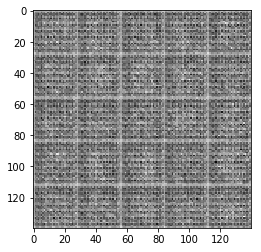




Current Epoch 1/2 
 Discriminator Loss is : 1.5644 
 Generator Loss is : 0.5097



Current Epoch 1/2 
 Discriminator Loss is : 1.3979 
 Generator Loss is : 0.6584



Current Epoch 1/2 
 Discriminator Loss is : 1.4259 
 Generator Loss is : 0.6913



Current Epoch 1/2 
 Discriminator Loss is : 1.1905 
 Generator Loss is : 0.8456



Current Epoch 1/2 
 Discriminator Loss is : 1.1695 
 Generator Loss is : 0.8491


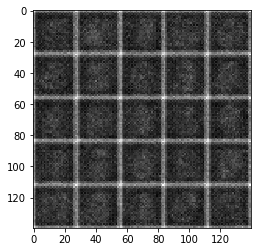




Current Epoch 1/2 
 Discriminator Loss is : 0.9474 
 Generator Loss is : 1.1153



Current Epoch 1/2 
 Discriminator Loss is : 1.1894 
 Generator Loss is : 0.8253



Current Epoch 1/2 
 Discriminator Loss is : 1.0604 
 Generator Loss is : 1.0473



Current Epoch 1/2 
 Discriminator Loss is : 1.0256 
 Generator Loss is : 1.1427



Current Epoch 1/2 
 Discriminator Loss is : 1.0775 
 Generator Loss is : 1.0674


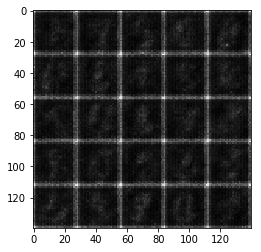




Current Epoch 1/2 
 Discriminator Loss is : 1.0516 
 Generator Loss is : 1.2301



Current Epoch 1/2 
 Discriminator Loss is : 0.9914 
 Generator Loss is : 1.1300



Current Epoch 1/2 
 Discriminator Loss is : 1.0706 
 Generator Loss is : 0.9624



Current Epoch 1/2 
 Discriminator Loss is : 1.0007 
 Generator Loss is : 1.1255



Current Epoch 1/2 
 Discriminator Loss is : 0.9065 
 Generator Loss is : 1.2647


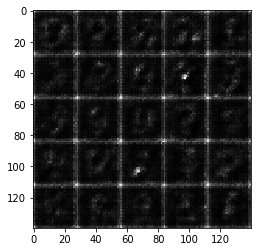




Current Epoch 1/2 
 Discriminator Loss is : 1.0324 
 Generator Loss is : 0.8364



Current Epoch 1/2 
 Discriminator Loss is : 0.9394 
 Generator Loss is : 1.4099



Current Epoch 1/2 
 Discriminator Loss is : 0.8167 
 Generator Loss is : 1.3666



Current Epoch 1/2 
 Discriminator Loss is : 0.8858 
 Generator Loss is : 1.0208



Current Epoch 1/2 
 Discriminator Loss is : 0.7773 
 Generator Loss is : 1.7303


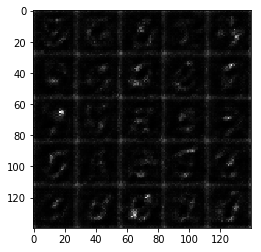




Current Epoch 1/2 
 Discriminator Loss is : 0.7260 
 Generator Loss is : 1.3531



Current Epoch 1/2 
 Discriminator Loss is : 0.7523 
 Generator Loss is : 2.0883



Current Epoch 1/2 
 Discriminator Loss is : 0.6822 
 Generator Loss is : 1.4902



Current Epoch 1/2 
 Discriminator Loss is : 0.6549 
 Generator Loss is : 1.6023



Current Epoch 1/2 
 Discriminator Loss is : 0.6217 
 Generator Loss is : 1.7929


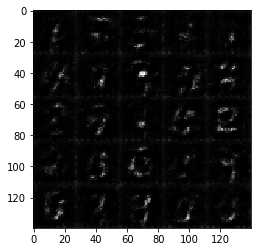




Current Epoch 1/2 
 Discriminator Loss is : 0.6013 
 Generator Loss is : 1.7700



Current Epoch 1/2 
 Discriminator Loss is : 0.6580 
 Generator Loss is : 1.4302



Current Epoch 1/2 
 Discriminator Loss is : 0.5626 
 Generator Loss is : 1.8667



Current Epoch 1/2 
 Discriminator Loss is : 0.5209 
 Generator Loss is : 2.1312



Current Epoch 1/2 
 Discriminator Loss is : 0.5038 
 Generator Loss is : 2.0793


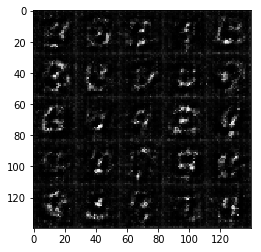




Current Epoch 1/2 
 Discriminator Loss is : 0.5547 
 Generator Loss is : 1.8292



Current Epoch 1/2 
 Discriminator Loss is : 0.4310 
 Generator Loss is : 2.7183



Current Epoch 1/2 
 Discriminator Loss is : 0.4856 
 Generator Loss is : 2.3313



Current Epoch 1/2 
 Discriminator Loss is : 0.5500 
 Generator Loss is : 1.7907



Current Epoch 1/2 
 Discriminator Loss is : 0.4232 
 Generator Loss is : 2.7617


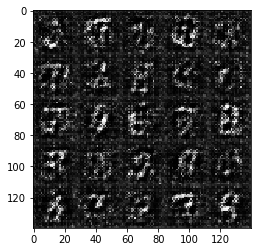




Current Epoch 1/2 
 Discriminator Loss is : 0.4724 
 Generator Loss is : 2.3877



Current Epoch 1/2 
 Discriminator Loss is : 0.4615 
 Generator Loss is : 2.2624



Current Epoch 1/2 
 Discriminator Loss is : 0.5436 
 Generator Loss is : 1.8432



Current Epoch 1/2 
 Discriminator Loss is : 0.4235 
 Generator Loss is : 3.0778



Current Epoch 1/2 
 Discriminator Loss is : 0.4352 
 Generator Loss is : 3.1433


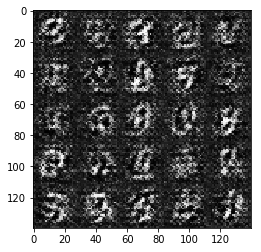




Current Epoch 1/2 
 Discriminator Loss is : 0.6075 
 Generator Loss is : 3.6062



Current Epoch 1/2 
 Discriminator Loss is : 0.4842 
 Generator Loss is : 2.5130



Current Epoch 1/2 
 Discriminator Loss is : 0.5008 
 Generator Loss is : 2.3341



Current Epoch 1/2 
 Discriminator Loss is : 0.4161 
 Generator Loss is : 2.9691



Current Epoch 1/2 
 Discriminator Loss is : 0.4158 
 Generator Loss is : 3.6281


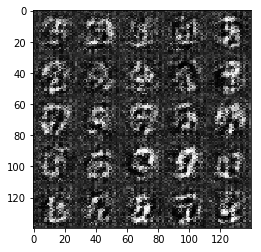




Current Epoch 1/2 
 Discriminator Loss is : 0.4067 
 Generator Loss is : 2.9414



Current Epoch 1/2 
 Discriminator Loss is : 0.4748 
 Generator Loss is : 2.8490



Current Epoch 1/2 
 Discriminator Loss is : 0.5401 
 Generator Loss is : 1.7808



Current Epoch 1/2 
 Discriminator Loss is : 0.3690 
 Generator Loss is : 3.7379



Current Epoch 1/2 
 Discriminator Loss is : 0.4133 
 Generator Loss is : 3.0564


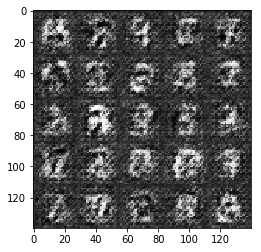




Current Epoch 1/2 
 Discriminator Loss is : 0.4113 
 Generator Loss is : 3.0602



Current Epoch 1/2 
 Discriminator Loss is : 1.0427 
 Generator Loss is : 4.7200



Current Epoch 1/2 
 Discriminator Loss is : 0.4832 
 Generator Loss is : 2.6466



Current Epoch 1/2 
 Discriminator Loss is : 0.5435 
 Generator Loss is : 1.8569



Current Epoch 1/2 
 Discriminator Loss is : 0.6478 
 Generator Loss is : 5.0481


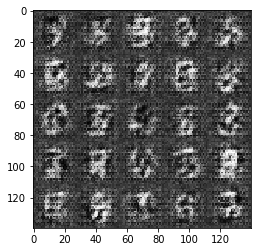




Current Epoch 1/2 
 Discriminator Loss is : 0.5386 
 Generator Loss is : 1.8543



Current Epoch 1/2 
 Discriminator Loss is : 1.7122 
 Generator Loss is : 5.9799



Current Epoch 1/2 
 Discriminator Loss is : 0.5482 
 Generator Loss is : 3.3694



Current Epoch 1/2 
 Discriminator Loss is : 0.5407 
 Generator Loss is : 1.8551



Current Epoch 1/2 
 Discriminator Loss is : 0.5063 
 Generator Loss is : 2.4646


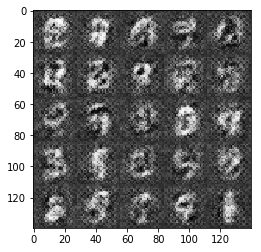




Current Epoch 1/2 
 Discriminator Loss is : 0.4437 
 Generator Loss is : 3.7260



Current Epoch 1/2 
 Discriminator Loss is : 0.5582 
 Generator Loss is : 3.0034



Current Epoch 1/2 
 Discriminator Loss is : 0.6682 
 Generator Loss is : 1.4496



Current Epoch 1/2 
 Discriminator Loss is : 0.5364 
 Generator Loss is : 4.1092



Current Epoch 1/2 
 Discriminator Loss is : 0.4224 
 Generator Loss is : 4.3764


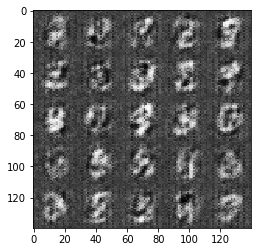




Current Epoch 1/2 
 Discriminator Loss is : 0.4360 
 Generator Loss is : 3.2657



Current Epoch 1/2 
 Discriminator Loss is : 0.4937 
 Generator Loss is : 3.3730



Current Epoch 1/2 
 Discriminator Loss is : 1.7157 
 Generator Loss is : 0.3201



Current Epoch 1/2 
 Discriminator Loss is : 0.3549 
 Generator Loss is : 5.5079



Current Epoch 1/2 
 Discriminator Loss is : 0.8235 
 Generator Loss is : 2.2176


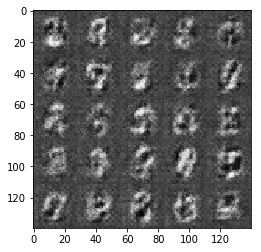




Current Epoch 1/2 
 Discriminator Loss is : 0.5740 
 Generator Loss is : 2.5304



Current Epoch 1/2 
 Discriminator Loss is : 0.4926 
 Generator Loss is : 2.1854



Current Epoch 1/2 
 Discriminator Loss is : 0.4775 
 Generator Loss is : 2.5099



Current Epoch 1/2 
 Discriminator Loss is : 0.4086 
 Generator Loss is : 3.1841



Current Epoch 1/2 
 Discriminator Loss is : 0.5598 
 Generator Loss is : 1.7260


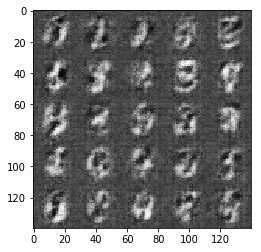




Current Epoch 1/2 
 Discriminator Loss is : 0.4934 
 Generator Loss is : 2.8108



Current Epoch 1/2 
 Discriminator Loss is : 0.5495 
 Generator Loss is : 1.8271



Current Epoch 1/2 
 Discriminator Loss is : 0.4212 
 Generator Loss is : 3.7826



Current Epoch 1/2 
 Discriminator Loss is : 0.9352 
 Generator Loss is : 0.8706



Current Epoch 1/2 
 Discriminator Loss is : 0.8172 
 Generator Loss is : 2.8187


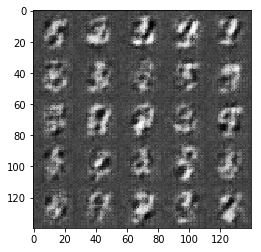




Current Epoch 1/2 
 Discriminator Loss is : 1.4383 
 Generator Loss is : 4.0533



Current Epoch 1/2 
 Discriminator Loss is : 0.9000 
 Generator Loss is : 1.2329



Current Epoch 1/2 
 Discriminator Loss is : 0.4618 
 Generator Loss is : 2.6728



Current Epoch 1/2 
 Discriminator Loss is : 0.5323 
 Generator Loss is : 1.9126



Current Epoch 1/2 
 Discriminator Loss is : 0.4445 
 Generator Loss is : 2.7793


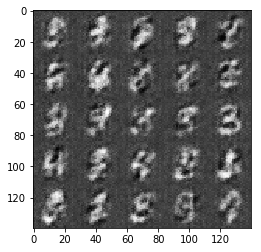




Current Epoch 1/2 
 Discriminator Loss is : 0.4819 
 Generator Loss is : 2.2162



Current Epoch 1/2 
 Discriminator Loss is : 0.4218 
 Generator Loss is : 3.1868



Current Epoch 1/2 
 Discriminator Loss is : 0.5513 
 Generator Loss is : 1.8207



Current Epoch 2...
Current Epoch 2/2 
 Discriminator Loss is : 0.4832 
 Generator Loss is : 2.2529



Current Epoch 2/2 
 Discriminator Loss is : 0.5877 
 Generator Loss is : 2.5495


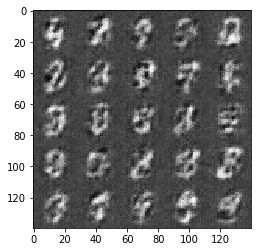




Current Epoch 2/2 
 Discriminator Loss is : 0.5526 
 Generator Loss is : 2.1246



Current Epoch 2/2 
 Discriminator Loss is : 0.4455 
 Generator Loss is : 2.7117



Current Epoch 2/2 
 Discriminator Loss is : 0.4823 
 Generator Loss is : 2.5067



Current Epoch 2/2 
 Discriminator Loss is : 0.5174 
 Generator Loss is : 2.6600



Current Epoch 2/2 
 Discriminator Loss is : 0.4747 
 Generator Loss is : 2.3647


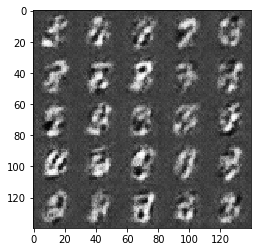




Current Epoch 2/2 
 Discriminator Loss is : 0.4654 
 Generator Loss is : 2.5421



Current Epoch 2/2 
 Discriminator Loss is : 0.4096 
 Generator Loss is : 3.2860



Current Epoch 2/2 
 Discriminator Loss is : 0.4960 
 Generator Loss is : 2.2648



Current Epoch 2/2 
 Discriminator Loss is : 0.4455 
 Generator Loss is : 2.8444



Current Epoch 2/2 
 Discriminator Loss is : 0.4367 
 Generator Loss is : 2.6427


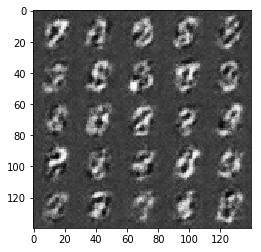




Current Epoch 2/2 
 Discriminator Loss is : 0.4759 
 Generator Loss is : 2.3254



Current Epoch 2/2 
 Discriminator Loss is : 0.5527 
 Generator Loss is : 3.1009



Current Epoch 2/2 
 Discriminator Loss is : 0.4364 
 Generator Loss is : 2.5691



Current Epoch 2/2 
 Discriminator Loss is : 0.4720 
 Generator Loss is : 2.2704



Current Epoch 2/2 
 Discriminator Loss is : 1.3199 
 Generator Loss is : 4.9174


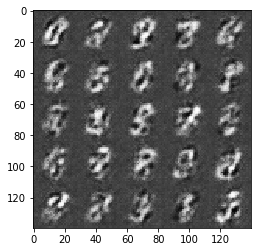




Current Epoch 2/2 
 Discriminator Loss is : 0.6038 
 Generator Loss is : 2.0454



Current Epoch 2/2 
 Discriminator Loss is : 0.7298 
 Generator Loss is : 1.3377



Current Epoch 2/2 
 Discriminator Loss is : 0.4624 
 Generator Loss is : 2.8308



Current Epoch 2/2 
 Discriminator Loss is : 0.4523 
 Generator Loss is : 2.5657



Current Epoch 2/2 
 Discriminator Loss is : 0.4551 
 Generator Loss is : 2.5586


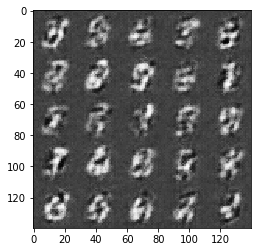




Current Epoch 2/2 
 Discriminator Loss is : 0.4790 
 Generator Loss is : 2.6095



Current Epoch 2/2 
 Discriminator Loss is : 0.4354 
 Generator Loss is : 2.6185



Current Epoch 2/2 
 Discriminator Loss is : 0.4350 
 Generator Loss is : 2.7639



Current Epoch 2/2 
 Discriminator Loss is : 0.4321 
 Generator Loss is : 2.9872



Current Epoch 2/2 
 Discriminator Loss is : 0.4682 
 Generator Loss is : 2.2880


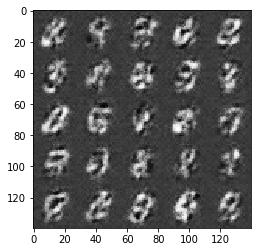




Current Epoch 2/2 
 Discriminator Loss is : 0.4013 
 Generator Loss is : 3.0554



Current Epoch 2/2 
 Discriminator Loss is : 0.4195 
 Generator Loss is : 2.8644



Current Epoch 2/2 
 Discriminator Loss is : 0.4303 
 Generator Loss is : 2.7189



Current Epoch 2/2 
 Discriminator Loss is : 0.4237 
 Generator Loss is : 3.0409



Current Epoch 2/2 
 Discriminator Loss is : 0.4369 
 Generator Loss is : 2.9034


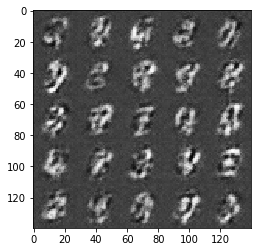




Current Epoch 2/2 
 Discriminator Loss is : 0.4247 
 Generator Loss is : 2.8686



Current Epoch 2/2 
 Discriminator Loss is : 1.0152 
 Generator Loss is : 0.7975



Current Epoch 2/2 
 Discriminator Loss is : 0.8904 
 Generator Loss is : 1.0022



Current Epoch 2/2 
 Discriminator Loss is : 0.5713 
 Generator Loss is : 2.0582



Current Epoch 2/2 
 Discriminator Loss is : 0.5502 
 Generator Loss is : 2.2567


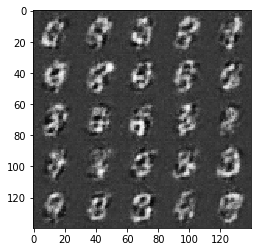




Current Epoch 2/2 
 Discriminator Loss is : 0.4470 
 Generator Loss is : 2.8176



Current Epoch 2/2 
 Discriminator Loss is : 0.5724 
 Generator Loss is : 1.8100



Current Epoch 2/2 
 Discriminator Loss is : 0.4573 
 Generator Loss is : 2.4284



Current Epoch 2/2 
 Discriminator Loss is : 0.4656 
 Generator Loss is : 2.8633



Current Epoch 2/2 
 Discriminator Loss is : 0.5040 
 Generator Loss is : 2.0390


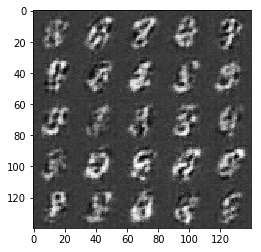




Current Epoch 2/2 
 Discriminator Loss is : 0.4341 
 Generator Loss is : 2.6595



Current Epoch 2/2 
 Discriminator Loss is : 0.4330 
 Generator Loss is : 3.0962



Current Epoch 2/2 
 Discriminator Loss is : 0.4501 
 Generator Loss is : 2.6430



Current Epoch 2/2 
 Discriminator Loss is : 0.4468 
 Generator Loss is : 3.2932



Current Epoch 2/2 
 Discriminator Loss is : 0.4806 
 Generator Loss is : 2.7458


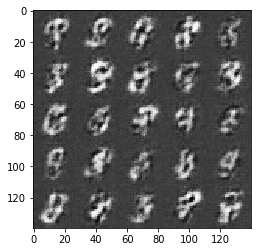




Current Epoch 2/2 
 Discriminator Loss is : 0.9285 
 Generator Loss is : 4.2330



Current Epoch 2/2 
 Discriminator Loss is : 0.5902 
 Generator Loss is : 2.1904



Current Epoch 2/2 
 Discriminator Loss is : 0.4199 
 Generator Loss is : 3.3421



Current Epoch 2/2 
 Discriminator Loss is : 0.4052 
 Generator Loss is : 3.1536



Current Epoch 2/2 
 Discriminator Loss is : 0.4479 
 Generator Loss is : 3.0483


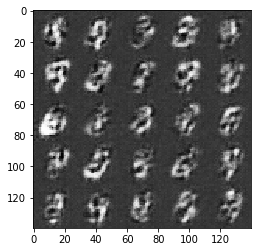




Current Epoch 2/2 
 Discriminator Loss is : 0.4648 
 Generator Loss is : 2.5054



Current Epoch 2/2 
 Discriminator Loss is : 0.4134 
 Generator Loss is : 3.3168



Current Epoch 2/2 
 Discriminator Loss is : 0.4594 
 Generator Loss is : 2.9830



Current Epoch 2/2 
 Discriminator Loss is : 0.4206 
 Generator Loss is : 3.1876



Current Epoch 2/2 
 Discriminator Loss is : 0.3981 
 Generator Loss is : 3.6072


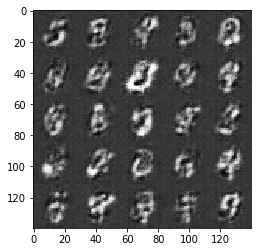




Current Epoch 2/2 
 Discriminator Loss is : 0.4528 
 Generator Loss is : 2.4578



Current Epoch 2/2 
 Discriminator Loss is : 0.4123 
 Generator Loss is : 2.9478



Current Epoch 2/2 
 Discriminator Loss is : 0.4445 
 Generator Loss is : 2.5387



Current Epoch 2/2 
 Discriminator Loss is : 0.4128 
 Generator Loss is : 3.4122



Current Epoch 2/2 
 Discriminator Loss is : 0.4599 
 Generator Loss is : 2.3603


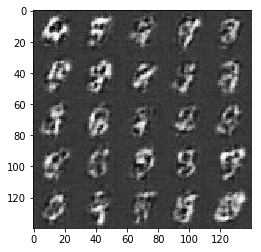




Current Epoch 2/2 
 Discriminator Loss is : 0.4410 
 Generator Loss is : 2.8034



Current Epoch 2/2 
 Discriminator Loss is : 1.4761 
 Generator Loss is : 0.4671



Current Epoch 2/2 
 Discriminator Loss is : 0.6042 
 Generator Loss is : 1.7851



Current Epoch 2/2 
 Discriminator Loss is : 0.5284 
 Generator Loss is : 2.5485



Current Epoch 2/2 
 Discriminator Loss is : 0.4624 
 Generator Loss is : 2.6484


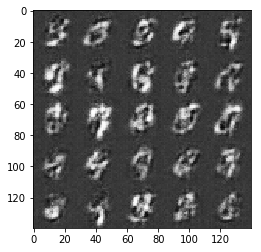




Current Epoch 2/2 
 Discriminator Loss is : 0.4529 
 Generator Loss is : 2.5535



Current Epoch 2/2 
 Discriminator Loss is : 0.4018 
 Generator Loss is : 3.3344



Current Epoch 2/2 
 Discriminator Loss is : 0.4090 
 Generator Loss is : 3.0287



Current Epoch 2/2 
 Discriminator Loss is : 0.4171 
 Generator Loss is : 3.2012



Current Epoch 2/2 
 Discriminator Loss is : 0.4670 
 Generator Loss is : 2.2930


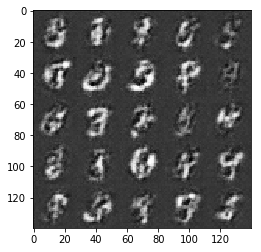




Current Epoch 2/2 
 Discriminator Loss is : 0.4181 
 Generator Loss is : 2.9476



Current Epoch 2/2 
 Discriminator Loss is : 0.4271 
 Generator Loss is : 3.5449



Current Epoch 2/2 
 Discriminator Loss is : 0.3919 
 Generator Loss is : 3.2313



Current Epoch 2/2 
 Discriminator Loss is : 0.4028 
 Generator Loss is : 3.6048



Current Epoch 2/2 
 Discriminator Loss is : 0.4684 
 Generator Loss is : 2.2535


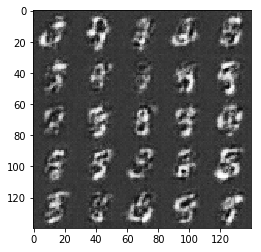




Current Epoch 2/2 
 Discriminator Loss is : 0.3958 
 Generator Loss is : 3.2521



Current Epoch 2/2 
 Discriminator Loss is : 0.4165 
 Generator Loss is : 3.5111



Current Epoch 2/2 
 Discriminator Loss is : 0.4488 
 Generator Loss is : 2.7639



Current Epoch 2/2 
 Discriminator Loss is : 0.8352 
 Generator Loss is : 4.4363



Current Epoch 2/2 
 Discriminator Loss is : 0.5802 
 Generator Loss is : 2.5036


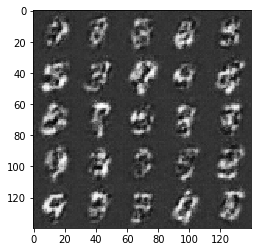




Current Epoch 2/2 
 Discriminator Loss is : 0.5117 
 Generator Loss is : 2.1712



Current Epoch 2/2 
 Discriminator Loss is : 0.4284 
 Generator Loss is : 2.7567



Current Epoch 2/2 
 Discriminator Loss is : 0.4377 
 Generator Loss is : 2.5559



Current Epoch 2/2 
 Discriminator Loss is : 0.3988 
 Generator Loss is : 3.0983



Current Epoch 2/2 
 Discriminator Loss is : 0.4911 
 Generator Loss is : 2.1392


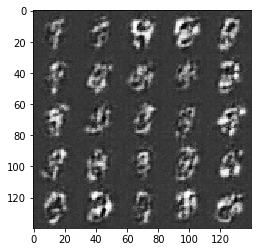




Current Epoch 2/2 
 Discriminator Loss is : 0.4485 
 Generator Loss is : 2.7043



Current Epoch 2/2 
 Discriminator Loss is : 0.4566 
 Generator Loss is : 2.3919



Current Epoch 2/2 
 Discriminator Loss is : 0.4321 
 Generator Loss is : 3.9159



Current Epoch 2/2 
 Discriminator Loss is : 0.4164 
 Generator Loss is : 3.1585



Current Epoch 2/2 
 Discriminator Loss is : 0.6475 
 Generator Loss is : 4.1736


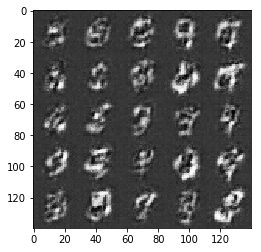




Current Epoch 2/2 
 Discriminator Loss is : 0.5228 
 Generator Loss is : 2.6030



Current Epoch 2/2 
 Discriminator Loss is : 0.4037 
 Generator Loss is : 3.0333





In [76]:
batch_size = 128
z_dim = 256
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

#mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Current Epoch 1...
Current Epoch 1/1 
 Discriminator Loss is : 2.4928 
 Generator Loss is : 0.1819



Current Epoch 1/1 
 Discriminator Loss is : 2.5105 
 Generator Loss is : 0.1950



Current Epoch 1/1 
 Discriminator Loss is : 1.5938 
 Generator Loss is : 0.5714



Current Epoch 1/1 
 Discriminator Loss is : 1.5190 
 Generator Loss is : 0.6032



Current Epoch 1/1 
 Discriminator Loss is : 1.4311 
 Generator Loss is : 0.7057


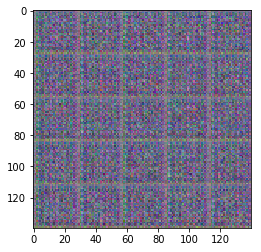




Current Epoch 1/1 
 Discriminator Loss is : 1.1652 
 Generator Loss is : 0.8355



Current Epoch 1/1 
 Discriminator Loss is : 1.3164 
 Generator Loss is : 0.7719



Current Epoch 1/1 
 Discriminator Loss is : 0.9780 
 Generator Loss is : 1.1768



Current Epoch 1/1 
 Discriminator Loss is : 1.1956 
 Generator Loss is : 1.0295



Current Epoch 1/1 
 Discriminator Loss is : 1.0361 
 Generator Loss is : 1.1126


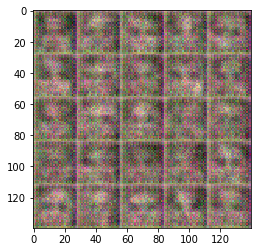




Current Epoch 1/1 
 Discriminator Loss is : 0.9462 
 Generator Loss is : 1.3518



Current Epoch 1/1 
 Discriminator Loss is : 0.9723 
 Generator Loss is : 1.5869



Current Epoch 1/1 
 Discriminator Loss is : 0.8422 
 Generator Loss is : 1.5175



Current Epoch 1/1 
 Discriminator Loss is : 0.8173 
 Generator Loss is : 1.4375



Current Epoch 1/1 
 Discriminator Loss is : 0.8154 
 Generator Loss is : 1.3893


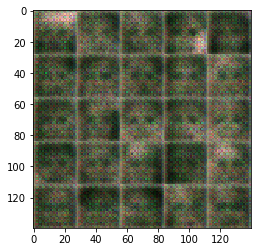




Current Epoch 1/1 
 Discriminator Loss is : 0.6707 
 Generator Loss is : 1.8049



Current Epoch 1/1 
 Discriminator Loss is : 0.5807 
 Generator Loss is : 2.2600



Current Epoch 1/1 
 Discriminator Loss is : 0.6160 
 Generator Loss is : 2.2423



Current Epoch 1/1 
 Discriminator Loss is : 0.5525 
 Generator Loss is : 2.1433



Current Epoch 1/1 
 Discriminator Loss is : 0.5974 
 Generator Loss is : 2.1323


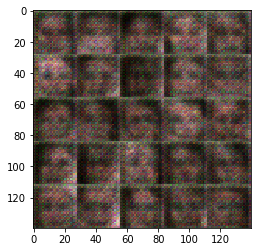




Current Epoch 1/1 
 Discriminator Loss is : 0.6195 
 Generator Loss is : 1.6971



Current Epoch 1/1 
 Discriminator Loss is : 0.4856 
 Generator Loss is : 2.5872



Current Epoch 1/1 
 Discriminator Loss is : 0.5562 
 Generator Loss is : 1.9498



Current Epoch 1/1 
 Discriminator Loss is : 0.4226 
 Generator Loss is : 3.2034



Current Epoch 1/1 
 Discriminator Loss is : 0.6380 
 Generator Loss is : 1.6308


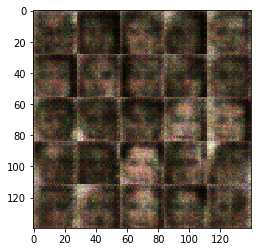




Current Epoch 1/1 
 Discriminator Loss is : 0.4266 
 Generator Loss is : 3.3975



Current Epoch 1/1 
 Discriminator Loss is : 0.5512 
 Generator Loss is : 1.9668



Current Epoch 1/1 
 Discriminator Loss is : 0.5053 
 Generator Loss is : 2.3076



Current Epoch 1/1 
 Discriminator Loss is : 0.3875 
 Generator Loss is : 3.8225



Current Epoch 1/1 
 Discriminator Loss is : 0.6913 
 Generator Loss is : 1.4363


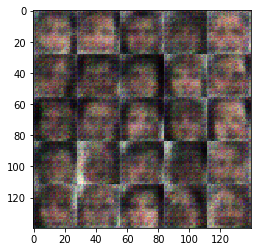




Current Epoch 1/1 
 Discriminator Loss is : 0.4959 
 Generator Loss is : 2.9939



Current Epoch 1/1 
 Discriminator Loss is : 0.3834 
 Generator Loss is : 3.6819



Current Epoch 1/1 
 Discriminator Loss is : 0.3725 
 Generator Loss is : 5.2036



Current Epoch 1/1 
 Discriminator Loss is : 0.5672 
 Generator Loss is : 1.8108



Current Epoch 1/1 
 Discriminator Loss is : 0.4705 
 Generator Loss is : 5.2121


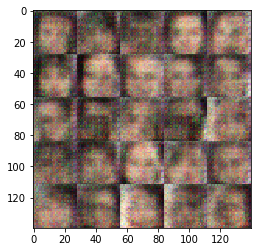




Current Epoch 1/1 
 Discriminator Loss is : 0.4360 
 Generator Loss is : 2.8249



Current Epoch 1/1 
 Discriminator Loss is : 0.3765 
 Generator Loss is : 5.8343



Current Epoch 1/1 
 Discriminator Loss is : 0.3986 
 Generator Loss is : 3.6854



Current Epoch 1/1 
 Discriminator Loss is : 0.3534 
 Generator Loss is : 5.6090



Current Epoch 1/1 
 Discriminator Loss is : 0.3913 
 Generator Loss is : 4.9248


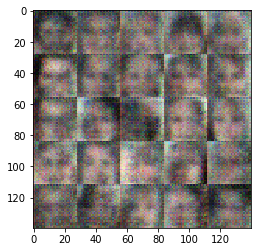




Current Epoch 1/1 
 Discriminator Loss is : 0.6013 
 Generator Loss is : 1.6675



Current Epoch 1/1 
 Discriminator Loss is : 0.3949 
 Generator Loss is : 5.8856



Current Epoch 1/1 
 Discriminator Loss is : 0.4212 
 Generator Loss is : 2.8962



Current Epoch 1/1 
 Discriminator Loss is : 1.0679 
 Generator Loss is : 0.9099



Current Epoch 1/1 
 Discriminator Loss is : 0.3721 
 Generator Loss is : 6.6012


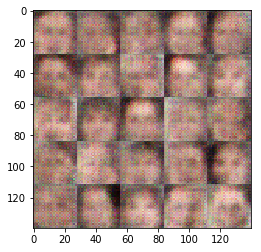




Current Epoch 1/1 
 Discriminator Loss is : 0.3785 
 Generator Loss is : 4.6626



Current Epoch 1/1 
 Discriminator Loss is : 0.3863 
 Generator Loss is : 5.9841



Current Epoch 1/1 
 Discriminator Loss is : 0.3746 
 Generator Loss is : 3.7830



Current Epoch 1/1 
 Discriminator Loss is : 0.3706 
 Generator Loss is : 4.0346



Current Epoch 1/1 
 Discriminator Loss is : 0.3829 
 Generator Loss is : 7.1602


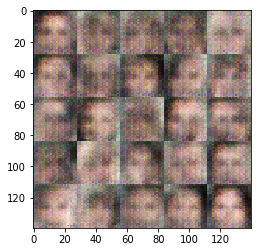




Current Epoch 1/1 
 Discriminator Loss is : 0.3530 
 Generator Loss is : 7.9642



Current Epoch 1/1 
 Discriminator Loss is : 0.3931 
 Generator Loss is : 7.6579



Current Epoch 1/1 
 Discriminator Loss is : 0.4059 
 Generator Loss is : 3.4786



Current Epoch 1/1 
 Discriminator Loss is : 1.7162 
 Generator Loss is : 11.5552



Current Epoch 1/1 
 Discriminator Loss is : 1.9397 
 Generator Loss is : 2.4580


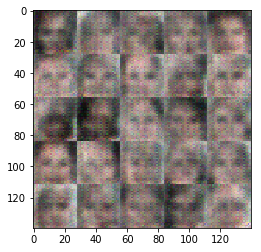




Current Epoch 1/1 
 Discriminator Loss is : 1.3973 
 Generator Loss is : 0.4969



Current Epoch 1/1 
 Discriminator Loss is : 1.0207 
 Generator Loss is : 0.7998



Current Epoch 1/1 
 Discriminator Loss is : 1.0259 
 Generator Loss is : 4.0584



Current Epoch 1/1 
 Discriminator Loss is : 0.3754 
 Generator Loss is : 5.7069



Current Epoch 1/1 
 Discriminator Loss is : 0.5785 
 Generator Loss is : 2.1576


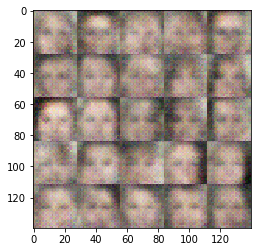




Current Epoch 1/1 
 Discriminator Loss is : 0.3622 
 Generator Loss is : 5.4900



Current Epoch 1/1 
 Discriminator Loss is : 0.3534 
 Generator Loss is : 6.7647



Current Epoch 1/1 
 Discriminator Loss is : 0.3922 
 Generator Loss is : 8.6790



Current Epoch 1/1 
 Discriminator Loss is : 0.3466 
 Generator Loss is : 9.4489



Current Epoch 1/1 
 Discriminator Loss is : 0.4746 
 Generator Loss is : 2.2594


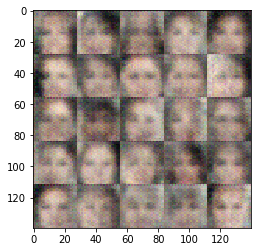




Current Epoch 1/1 
 Discriminator Loss is : 0.3537 
 Generator Loss is : 5.0467



Current Epoch 1/1 
 Discriminator Loss is : 0.3475 
 Generator Loss is : 14.7474



Current Epoch 1/1 
 Discriminator Loss is : 0.5955 
 Generator Loss is : 1.5996



Current Epoch 1/1 
 Discriminator Loss is : 0.3876 
 Generator Loss is : 3.2483



Current Epoch 1/1 
 Discriminator Loss is : 0.3645 
 Generator Loss is : 6.8268


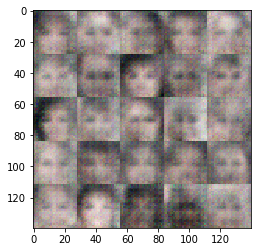




Current Epoch 1/1 
 Discriminator Loss is : 0.5335 
 Generator Loss is : 4.8016



Current Epoch 1/1 
 Discriminator Loss is : 0.9155 
 Generator Loss is : 0.9108



Current Epoch 1/1 
 Discriminator Loss is : 0.3523 
 Generator Loss is : 9.7799



Current Epoch 1/1 
 Discriminator Loss is : 0.3634 
 Generator Loss is : 4.9523



Current Epoch 1/1 
 Discriminator Loss is : 0.4375 
 Generator Loss is : 9.5217


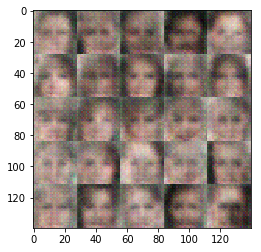




Current Epoch 1/1 
 Discriminator Loss is : 2.2173 
 Generator Loss is : 0.1817



Current Epoch 1/1 
 Discriminator Loss is : 0.5653 
 Generator Loss is : 2.7955



Current Epoch 1/1 
 Discriminator Loss is : 0.4565 
 Generator Loss is : 8.1364



Current Epoch 1/1 
 Discriminator Loss is : 0.5288 
 Generator Loss is : 3.8281



Current Epoch 1/1 
 Discriminator Loss is : 1.3783 
 Generator Loss is : 10.2500


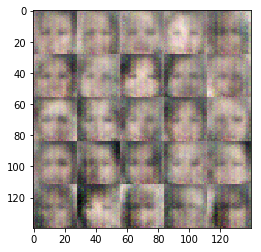




Current Epoch 1/1 
 Discriminator Loss is : 0.3507 
 Generator Loss is : 4.7098



Current Epoch 1/1 
 Discriminator Loss is : 1.0478 
 Generator Loss is : 0.7254



Current Epoch 1/1 
 Discriminator Loss is : 0.3947 
 Generator Loss is : 3.9719



Current Epoch 1/1 
 Discriminator Loss is : 0.6612 
 Generator Loss is : 7.4457



Current Epoch 1/1 
 Discriminator Loss is : 0.3469 
 Generator Loss is : 9.6750


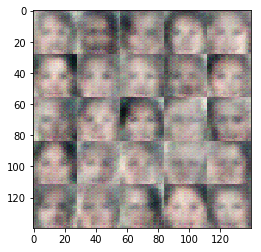




Current Epoch 1/1 
 Discriminator Loss is : 0.4511 
 Generator Loss is : 7.5636



Current Epoch 1/1 
 Discriminator Loss is : 0.3794 
 Generator Loss is : 4.8419



Current Epoch 1/1 
 Discriminator Loss is : 0.4152 
 Generator Loss is : 2.8257



Current Epoch 1/1 
 Discriminator Loss is : 0.6813 
 Generator Loss is : 15.6650



Current Epoch 1/1 
 Discriminator Loss is : 0.3476 
 Generator Loss is : 13.3060


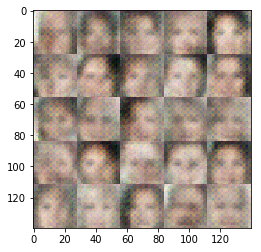




Current Epoch 1/1 
 Discriminator Loss is : 0.5775 
 Generator Loss is : 2.0088



Current Epoch 1/1 
 Discriminator Loss is : 0.3559 
 Generator Loss is : 4.5007



Current Epoch 1/1 
 Discriminator Loss is : 0.3548 
 Generator Loss is : 5.0642



Current Epoch 1/1 
 Discriminator Loss is : 0.3541 
 Generator Loss is : 5.2624



Current Epoch 1/1 
 Discriminator Loss is : 0.3757 
 Generator Loss is : 5.0376


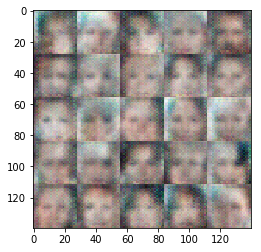




Current Epoch 1/1 
 Discriminator Loss is : 0.6454 
 Generator Loss is : 1.4642



Current Epoch 1/1 
 Discriminator Loss is : 0.3609 
 Generator Loss is : 10.1927



Current Epoch 1/1 
 Discriminator Loss is : 0.3488 
 Generator Loss is : 12.7665



Current Epoch 1/1 
 Discriminator Loss is : 0.4152 
 Generator Loss is : 7.7082



Current Epoch 1/1 
 Discriminator Loss is : 0.3575 
 Generator Loss is : 5.3048


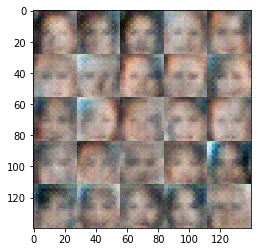




Current Epoch 1/1 
 Discriminator Loss is : 0.8990 
 Generator Loss is : 0.9497





In [77]:
batch_size = 256
z_dim = 256
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

#celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

### My personal oppion
Actually, I didn't approve this result, I had spent more than 2 day to tune the hyper paramenters, and tried servel sturcture to experience the model, but DCGAN seems like the black box. Behold, there's a black magic called DCGAN. But a week ago, I read about an paper about BEGAN.
I saw the incrablly result of face generation, so I want to try it.

In [58]:
import glob
import time
import numpy as np
import tensorflow as tf

def conv2d(x, filter_shape, bias=True, stride=1, padding="SAME", name="conv2d"):
    kw, kh, nin, nout = filter_shape
    pad_size = (kw - 1) / 2

    if padding == "VALID":
        x = tf.pad(x, [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], "SYMMETRIC")

    initializer = tf.random_normal_initializer(0., 0.02)
    with tf.variable_scope(name):
        weight = tf.get_variable("weight", shape=filter_shape, initializer=initializer)
        x = tf.nn.conv2d(x, weight, [1, stride, stride, 1], padding=padding)

        if bias:
            b = tf.get_variable("bias", shape=filter_shape[-1], initializer=tf.constant_initializer(0.))
            x = tf.nn.bias_add(x, b)
    return x

def fc(x, output_shape, bias=True, name='fc'):
    shape = x.get_shape().as_list()
    dim = np.prod(shape[1:])
    x = tf.reshape(x, [-1, dim])
    input_shape = dim

    initializer = tf.random_normal_initializer(0., 0.02)
    with tf.variable_scope(name):
        weight = tf.get_variable("weight", shape=[input_shape, output_shape], initializer=initializer)
        x = tf.matmul(x, weight)

        if bias:
            b = tf.get_variable("bias", shape=[output_shape], initializer=tf.constant_initializer(0.))
            x = tf.nn.bias_add(x, b)
    return x

def pool(x, r=2, s=1):
    return tf.nn.avg_pool(x, ksize=[1, r, r, 1], strides=[1, s, s, 1], padding="SAME")


def l1_loss(x, y):
    return tf.reduce_mean(tf.abs(x - y))


def resize_nn(x, size):
    return tf.image.resize_nearest_neighbor(x, size=(int(size), int(size)))

In [59]:
def generator_Bgcen(x, reuse=None, data_size = 64, filter_number=64):
    with tf.variable_scope('generator') as scope:
        if reuse:
            scope.reuse_variables()

        w = data_size
        f = filter_number
        p = "SAME"

        x = fc(x, 8 * 8 * f, name='fc')
        x = tf.reshape(x, [-1, 8, 8, f])

        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv1_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv1_b')
        x = tf.nn.elu(x)

        if data_size == 128:
            x = resize_nn(x, w / 8)
            x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv2_a')
            x = tf.nn.elu(x)
            x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv2_b')
            x = tf.nn.elu(x)

        x = resize_nn(x, w / 4)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv3_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv3_b')
        x = tf.nn.elu(x)

        x = resize_nn(x, w / 2)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv4_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv4_b')
        x = tf.nn.elu(x)

        x = resize_nn(x, w)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p,name='conv5_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p,name='conv5_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [3, 3, f, 3], stride=1,  padding=p,name='conv6_a')
    return x

In [60]:
def encoder(x, reuse=None, data_size=64, filter_number=64, embedding=64):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()

        f = filter_number
        h = embedding
        p = "SAME"

        x = conv2d(x, [3, 3, 3, f], stride=1,  padding=p,name='conv1_enc_a')
        x = tf.nn.elu(x)

        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p,name='conv2_enc_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p,name='conv2_enc_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [1, 1, f, 2 * f], stride=1,  padding=p,name='conv3_enc_0')
        x = pool(x, r=2, s=2)
        x = conv2d(x, [3, 3, 2 * f, 2 * f], stride=1,  padding=p,name='conv3_enc_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, 2 * f, 2 * f], stride=1,  padding=p,name='conv3_enc_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [1, 1, 2 * f, 3 * f], stride=1,  padding=p,name='conv4_enc_0')
        x = pool(x, r=2, s=2)
        x = conv2d(x, [3, 3, 3 * f, 3 * f], stride=1,  padding=p,name='conv4_enc_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, 3 * f, 3 * f], stride=1,  padding=p,name='conv4_enc_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [1, 1, 3 * f, 4 * f], stride=1,  padding=p,name='conv5_enc_0')
        x = pool(x, r=2, s=2)
        x = conv2d(x, [3, 3, 4 * f, 4 * f], stride=1,  padding=p,name='conv5_enc_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, 4 * f, 4 * f], stride=1,  padding=p,name='conv5_enc_b')
        x = tf.nn.elu(x)

        if data_size == 128:
            x = conv2d(x, [1, 1, 4 * f, 5 * f], stride=1,  padding=p,name='conv6_enc_0')
            x = pool(x, r=2, s=2)
            x = conv2d(x, [3, 3, 5 * f, 5 * f], stride=1,  padding=p,name='conv6_enc_a')
            x = tf.nn.elu(x)
            x = conv2d(x, [3, 3, 5 * f, 5 * f], stride=1,  padding=p,name='conv6_enc_b')
            x = tf.nn.elu(x)

        x = fc(x, h, name='enc_fc')
    return x

In [61]:
def decoder(x, reuse=None, data_size=64, filter_number=64):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()

        w = data_size
        f = filter_number
        p = "SAME"

        x = fc(x, 8 * 8 * f, name='fc')
        x = tf.reshape(x, [-1, 8, 8, f])

        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv1_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv1_b')
        x = tf.nn.elu(x)

        if data_size == 128:
            x = resize_nn(x, w / 8)
            x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv2_a')
            x = tf.nn.elu(x)
            x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv2_b')
            x = tf.nn.elu(x)

            x = resize_nn(x, w / 4)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv3_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv3_b')
        x = tf.nn.elu(x)

        x = resize_nn(x, w / 2)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv4_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv4_b')
        x = tf.nn.elu(x)

        x = resize_nn(x, w)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv5_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv5_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [3, 3, f, 3], stride=1, padding=p, name='conv6_a')
    return x

In [62]:
#Misc
flag = True
gpu_number = 0
image_size = 64

# Train Iteration
niter = 50
niter_snapshot = 2440
max_to_keep = 5

#Train Parameter
batch_size = 16
learning_rate = 1e-4
mm = 0.5 #momentum
mm2 = 0.5 #momentum2
lamda = 0.001
gamma = 0.5
filter_number = 64
input_size = 64
embedding = 64

In [63]:
def Model_Input(batch_size, input_size, data_size):
    x = tf.placeholder(tf.float32, shape=[batch_size, input_size], name='x')
    y = tf.placeholder(tf.float32, shape=[batch_size, data_size, data_size, 3], name='y')
    kt = tf.placeholder(tf.float32, name='kt')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    return x, y, kt, learning_rate

In [64]:
def Model_Loss(y, gen, d_real, d_fake, kt, gamma):
    d_real_loss = l1_loss(y, d_real)
    d_fake_loss = l1_loss(gen, d_fake)
    d_loss = d_real_loss - kt * d_fake_loss
    m_global = d_real_loss + tf.abs(gamma * d_real_loss - d_fake_loss)
    return d_real_loss, d_fake_loss, d_loss, m_global

In [69]:
def Optimizer_BEGAN(g_vars, d_vars, lr, mm, g_loss, d_loss):
    opt_g = tf.train.AdamOptimizer(lr, mm).minimize(g_loss, var_list=g_vars)
    opt_d = tf.train.GradientDescentOptimizer(lr).minimize(d_loss, var_list=d_vars)
    return opt_g, opt_d

In [78]:
merged = None
writer = None
def train_Began(sess_, batch_size, get_batches, input_size, image_size, gamma, lamda, lr, mm, filter_number, data_shape, data_image_mode, embedding, 
          niter, niter_snapshot,  flag=True, Max_to_keep=10):
    _x, _y, _kt, _lr = Model_Input(batch_size, input_size, image_size)
    
    _recon_gen = generator_Bgcen(_x, filter_number=filter_number, data_size=image_size)
    _d_real = decoder(encoder(_y, data_size=image_size, embedding=embedding, filter_number=filter_number), 
                    filter_number=filter_number, data_size=image_size)
    _d_fake = decoder(encoder(_recon_gen, reuse=True, embedding=embedding, data_size=image_size, filter_number=filter_number), 
                    reuse=True, filter_number=filter_number,data_size=image_size)
    _recon_dec = decoder(_x, reuse=True, filter_number=filter_number, data_size=image_size)
    
    _d_real_loss, _d_fake_loss, _d_loss, _m_global = Model_Loss(_y, _recon_gen, _d_real, _d_fake, _kt, gamma)
    _g_loss = _d_fake_loss
    
    _g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "generator")
    _d_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "discriminator")
    
    _opt_g, _opt_d = Optimizer_BEGAN(_g_vars, _d_vars, _lr, mm, _g_loss, _d_loss)
    
    sess_.run(tf.global_variables_initializer())
    
    saver =  tf.train.Saver(max_to_keep=(Max_to_keep))
    
    if flag:
        tf.summary.scalar('loss/loss', _d_loss + _g_loss)
        tf.summary.scalar('loss/g_loss', _g_loss)
        tf.summary.scalar('loss/d_loss', _d_loss)
        tf.summary.scalar('loss/d_real_loss', _d_real_loss)
        tf.summary.scalar('loss/d_fake_loss', _d_fake_loss)
        tf.summary.scalar('misc/kt', _kt)
        tf.summary.scalar('misc/m_global', _m_global)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter(".", sess_.graph)
    
    start_time = time.time()
    kt_ = np.float32(0.)
    lr_ = np.float32(lr)
    count = 0
    
    for epoch in range (niter):
        m = 0
        for batch_images in get_batches(batch_size):
            count += 1
            m += 1
            batch_x = np.random.uniform(-1, 1, size=[batch_size, input_size])
            #batch_files = data[idx * self.batch_size: (idx + 1) * self.batch_size]
            #batch_data = [get_image(batch_file) for batch_file in batch_files]
            
            g_opt = [_opt_g, _g_loss, _d_real_loss, _d_fake_loss]
            d_opt = [_opt_d, _d_loss, merged]
            feed_dict = {_x: batch_x, _y: batch_images, _kt: kt_, _lr: lr}
            
            #train the model
            _, loss_g, d_real_loss, d_fake_loss = sess_.run(g_opt, feed_dict=feed_dict)
            _, loss_d, summary = sess_.run(d_opt, feed_dict=feed_dict)
            
            # update kt, m_global
            kt = np.maximum(np.minimum(1., kt_ + lamda * (gamma * d_real_loss - d_fake_loss)), 0.)
            m_global = d_real_loss + np.abs(gamma * d_real_loss - d_fake_loss)
            loss = loss_g + loss_d
            
            #print("Epoch: [%2d] [%4d/%4d] time: %4.4f, "
            #          "loss: %.4f, loss_g: %.4f, loss_d: %.4f, d_real: %.4f, d_fake: %.4f, kt: %.8f, M: %.8f"
            #          % (epoch, count, m, time.time() - start_time,
            #             loss, loss_g, loss_d, d_real_loss, d_fake_loss, kt, m_global))
            writer.add_summary(summary, count)
            
            if count % niter_snapshot == (niter_snapshot - 1):
                    # update learning rate
                    lr *= 0.95
                    saver.save(sess_, "BEGAN", global_step=count, write_meta_graph=False)
            
            if count%5 == 0:
                    print("Current Epoch {}/{} \n".format(epoch, niter),
                          "Discriminator Loss is : {:.4f} \n".format(loss_d),
                          "Generator Loss is : {:.4f}".format(loss_g))
                    if count%25 == 0:
                        print('\n')
                        test(sess_, batch_size, image_size, input_size, _recon_gen, _recon_dec, _x, data_image_mode, count)
                    print("\n")

def inverse_image(img):
    img = (img + 0.5) * 255.
    img[img > 255] = 255
    img[img < 0] = 0
    img = img[..., ::-1] # bgr to rgb
    return img
                    
def test(sess, batch_size, data_size, input_size, recon_gen, recon_dec, x, image_mode, idx):
        cmap = None if image_mode == 'RGB' else 'gray'
        # generate output
        img_num = batch_size
        img_size = data_size

        output_f = int(np.sqrt(img_num))
        im_output_gen = np.zeros([img_size * output_f, img_size * output_f, 3])

        test_data = np.random.uniform(-1., 1., size=[img_num, input_size])
        output_gen = (sess.run(recon_gen, feed_dict={x: test_data}))  # generator output
        output_dec = (sess.run(recon_dec, feed_dict={x: test_data}))  # decoder output
        
        images_grid = helper.images_square_grid(output_dec, image_mode)
        pyplot.imshow(images_grid, cmap=cmap)
        pyplot.show()

In [79]:
#Misc
flag = True
gpu_number = 0
image_size = 28

# Train Iteration
niter = 2
niter_snapshot = 2440
max_to_keep = 5

#Train Parameter
batch_size = 128
learning_rate = 1e-4
mm = 0.5 #momentum
mm2 = 0.5 #momentum2
lamda = 0.001
gamma = 0.4
filter_number = 28
input_size = 28
embedding = 28

Max_to_keep = 100

#celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    with tf.Session() as sess:
        train_Began(sess, batch_size, celeba_dataset.get_batches, input_size, image_size, gamma, lamda, learning_rate, mm, filter_number,
              celeba_dataset.shape, celeba_dataset.image_mode, embedding, niter, niter_snapshot, flag, Max_to_keep)

Current Epoch 0/2 
 Discriminator Loss is : 0.2167 
 Generator Loss is : 0.0001


Current Epoch 0/2 
 Discriminator Loss is : 0.2183 
 Generator Loss is : 0.0000


Current Epoch 0/2 
 Discriminator Loss is : 0.2218 
 Generator Loss is : 0.0000




KeyboardInterrupt: 